## Vanilla python Closed Form Solution

In [ ]:
from random import Random
from math import ceil, sqrt

'''
Parameters
N (int, optional): The number of random numbers to generate. The default value is 1000.
seed (int, optional): The seed value used to initialize the Random number generator. The default value is 5.

Purpose
The purpose of the comp_generate_num function is to generate two lists of N random floating-point numbers between 0 and 1, inclusive, 
using the specified seed value. The two lists are correlated in some way because they are generated using the same seed.

Output
The comp_generate_num function returns a tuple of two lists, where the first list contains N random numbers between 0 and 1, 
and the second list also contains N random numbers between 0 and 1. 
The two lists are generated using the same seed value, ensuring that they are correlated in some way.
'''

def comp_generate_num(N=1000):
  SEED = 5
  random_num = Random(x=SEED)
  return(
      [random_num.uniform(a=0,b=1)
      for _ in range(N)],
      [random_num.uniform(a=0,b=1)
      for _ in range(N)]
  )

"""
Parameters
x_p (float): The predicted x-coordinate.
y_p (float): The predicted y-coordinate.
batch_x (List[float]): A list of actual x-coordinates.
batch_y (List[float]): A list of actual y-coordinates.

Purpose
The purpose of the loss function is to calculate the average Euclidean distance between a predicted point and a batch of actual points.
It then calculates the Euclidean distance between each pair of coordinates in the batch and the predicted coordinates, and returns the average distance.

Output
The loss function returns a single floating-point number, which represents the average Euclidean distance between the predicted point and the batch of actual points.
"""

def loss(x_p, y_p, batch_x ,batch_y):
  return (1/len(batch_x))* sum([sqrt((x_i-x_p)**2+(y_i-y_p)**2) for x_i , y_i in zip(batch_x, batch_y)])

"""
    Calculates the gradient of the loss function with respect to the predicted point.

    Args:
        x_p (float): The predicted x-coordinate.
        y_p (float): The predicted y-coordinate.
        batch_x (List[float]): A list of actual x-coordinates.
        batch_y (List[float]): A list of actual y-coordinates.

    Returns:
        A tuple containing the gradient of the loss function with respect to the x-coordinate and y-coordinate.
    """

def calc_grad(x_p, y_p, batch_x ,batch_y):
  sum_x, sum_y = 0, 0
  n = len(batch_x)
  for x_i, y_i in zip(batch_x ,batch_y):
    inv_sqrt = ((x_i - x_p) ** 2 + (y_i - y_p) ** 2) ** (-0.5)
    sum_x += inv_sqrt * (x_i - x_p)
    sum_y += inv_sqrt * (y_i - y_p)
  return -sum_x/n, -sum_y/n


data_x, data_y = comp_generate_num(N=1)
x_p , y_p = 0.3 , 0.3
grad_x , grad_y = calc_grad(x_p, y_p, data_x ,data_y)
curr_loss = loss(x_p, y_p, data_x ,data_y)

print(f"Clsoed form: gradient for x_p = {grad_x}, gradient for y_p = {grad_y}")
print(f"Clsoed form: loss = {curr_loss}")

Clsoed form: gradient for x_p = -0.5900849147094943, gradient for y_p = -0.8073411877467226
Clsoed form: loss = 0.5472122517293468


## Pytorch auto-grad engine

In [ ]:
import torch as tc
pnt = tc.tensor([0.3 , 0.3])
pnt.requires_grad = True
pnt.retain_grad()
data_x, data_y = comp_generate_num(N=1)
data_tc = tc.tensor([data_x, data_y])
data_tc = data_tc.t()

# loss is true due to braodcasting
for i in range(1):
  loss_tc = tc.mean(tc.sqrt(((data_tc - pnt)**2).sum(dim = 1))) # forward path
  print(f"torch loss: {loss_tc}")
  loss_tc.backward()
  print(f"torch auto gradient: {pnt.grad.data}")

torch loss: 0.5472122430801392
torch auto gradient: tensor([-0.5901, -0.8073])


## Building our own Auto-Grad from scratch

### Reverse topological sort algorithm
* the nodes are ordered in such a way that for every directed edge (u, v), the node u comes after the node v in the ordering.

* the reverse topological sort algorithm starts with the nodes that have no outgoing edges, adds them to the ordering, and removes them from the graph. Then, it proceeds recursively to the remaining nodes until all nodes have been added to the ordering.

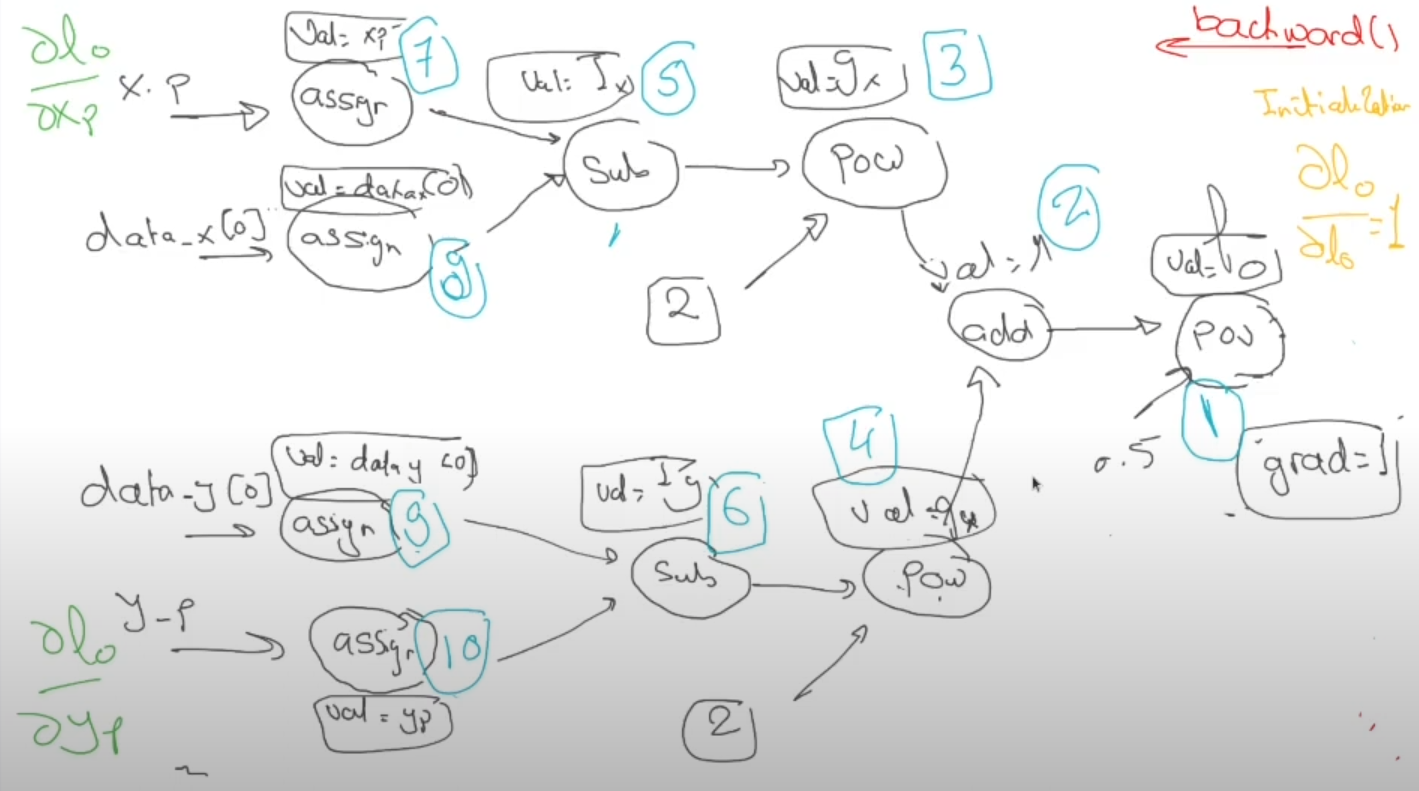

### Operator Overloading
To overload an operator in Python, you need to define a special method with a specific name that corresponds to the operator. For example, to overload the addition operator +, you would define a method named $__add__()$ in your class. The method should take two parameters, $\boxed {self}$ and $\boxed {other}$ , and return the result of the addition.

In [ ]:
class comp_node:
  def __init__(self, val, children =[] , op ="assign"):  # constructor
    self.val = val
    self.children = children
    self.grad = 0
    self.op = op
    self.backward_prop =  lambda : None
  
  """
  A private method that takes an object and returns it as a comp_node object if it is not already a comp_node.
  """
  def __to_comp_node(self, obj):
      if not isinstance(obj , comp_node):
        return comp_node(val = obj)
      else:
        return obj 

  """
  Overrides the - operator for subtraction. It returns a new comp_node object whose value is the difference of the two input nodes. 
  It takes in the following parameters:

  other : the node to subtract from the current node.
  """
  def __sub__(self, other):
    other = self.__to_comp_node(other)
    out = comp_node(val = self.val - other.val, children=[self , other], op = "sub")

    def __backward_prop():
      self.grad += out.grad * 1
      other.grad += out.grad * -1
    out.backward_prop = __backward_prop
    return out
      
  """
  Overrides the - operator for subtraction when the left operand is not a comp_node. It returns a new comp_node object whose value is the difference of the two input nodes. 
  It takes in the following parameters:

  other : the node to subtract from.
  """
  def __rsub__(self, other):
    other = self.__to_comp_node(other)
    return other - self

  """
  Overrides the + operator for addition. It returns a new comp_node object whose value is the sum of the two input nodes. 
  It takes in the following parameters:

  other : the node to add to the current node.
  """
  def __add__(self, other):
    other = self.__to_comp_node(other)
    out = comp_node(val = self.val + other.val, children=[self , other], op = "add")

    def __backward_prop():
      self.grad += out.grad * 1
      other.grad += out.grad * 1
    out.backward_prop = __backward_prop
    return out

  """
  Overrides the + operator for addition when the left operand is not a comp_node. It returns a new comp_node object whose value is the sum of the two input nodes. 
  It takes in the following parameters:

  other : the node to add to.
  """
  def __radd__(self, other):
    other = self.__to_comp_node(other)
    return other + self

  """
  Overrides the * operator for multiplication. It returns a new comp_node object whose value is the product of the two input nodes. 
  It takes in the following parameters:

  other : the node to multiply with the current node.
  """
  def __mul__(self, other):
      other = self.__to_comp_node(other)
      out = comp_node(val=self.val * other.val, children=[self, other], op="mul")
      def __backward_prop():
       self.grad += out.grad * other.val
       other.grad += out.grad * self.val
      out.backward_prop = __backward_prop 
      return out

  """
  Overrides the * operator for multiplication when the left operand is not a comp_node. It returns a new comp_node object whose value is the product of the two input nodes. 
  It takes in the following parameters:

  other : the node to multiply with.
  """
  def __rmul__(self, other):
      return self.__mul__(other)

  """
  Overrides the ** operator for exponentiation. It returns a new comp_node object whose value is the current node raised to the power of the exponent.
  It takes in the following parameters:

  exponent : the exponent to raise the current node to.
  """
  def __pow__(self, exponent):
    if not isinstance(exponent, (int, float)):
      raise ValueError("type not supported")
    out = comp_node(val = self.val ** exponent, children=[self], op = f"pow {exponent}")

    def __backward_prop():
      self.grad += out.grad * (exponent * self.val**(exponent - 1))
    out.backward_prop = __backward_prop
    return out

  """
  Overrides the == operator for equality check. It checks if the values of two comp_node objects are equal.
  It takes in the following parameters:

  other : the comp_node object to compare with the current node.
  """
  def __eq__(self,other):
    return self.val == other.val

  """
  Overrides the string representation of the comp_node object. It returns a string representation of the object,
  showing its value, number of children, operation, and gradient.
  """
  def __repr__(self):
    return f"comp_node(val= {self.val:0.5f} | children= {len(self.children)} | op= {self.op} | grad = {self.grad:0.5f} )"
  

In [ ]:
# Define two comp_node instances
a = comp_node(5)
b = comp_node(10)

# Test subtraction operator
c = a - b
assert c.val == -5

# Test reverse subtraction operator
d = 20 - b
assert d.val == 10

# Test addition operator
e = a + b
assert e.val == 15

# Test reverse addition operator
f = 20 + b
assert f.val == 30

# Test multiplication operator
g = a * b
assert g.val == 50

# Test reverse multiplication operator
h = 20 * b
assert h.val == 200

# Test power operator
i = a ** 2
assert i.val == 25

# Test equality operator
j = comp_node(5)
assert (a == j) == True
assert (a == b) == False

In [ ]:
data_x, data_y = comp_generate_num(N=1)
x_p , y_p = comp_node(val = 0.3) , comp_node(val = 0.3)
def loss_graph(x_p, y_p, data_x ,data_y):
  i_x, i_y = x_p - data_x , y_p - data_y
  g_x , g_y = i_x**2 , i_y**2
  m = g_x + g_y
  l = m **(0.5)
  return l ,[l, m, g_x, g_y, i_x, i_y, x_p, y_p]

ls , rev_topo_order = loss_graph(x_p, y_p, data_x[0] ,data_y[0])
rev_topo_order[0].grad = 1

# enumerate() is a built-in  function that allows you to 
# loop over an iterable object (like a list) and
# keep track of the index of each element in the list.
for i, node in enumerate(rev_topo_order):
  node.backward_prop()
  print(i, node)

0 comp_node(val= 0.54721 | children= 1 | op= pow 0.5 | grad = 1.00000 )
1 comp_node(val= 0.29944 | children= 2 | op= add | grad = 0.91372 )
2 comp_node(val= 0.10427 | children= 1 | op= pow 2 | grad = 0.91372 )
3 comp_node(val= 0.19518 | children= 1 | op= pow 2 | grad = 0.91372 )
4 comp_node(val= -0.32290 | children= 2 | op= sub | grad = -0.59008 )
5 comp_node(val= -0.44179 | children= 2 | op= sub | grad = -0.80734 )
6 comp_node(val= 0.30000 | children= 0 | op= assign | grad = -0.59008 )
7 comp_node(val= 0.30000 | children= 0 | op= assign | grad = -0.80734 )
